## Transfer Learning InceptionV3 using Keras

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [1]:
# import the libraries as shown below

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model, Sequential 
from tensorflow.keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import numpy as np
import itertools
import keras

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '../data/dataset_original/'
validation_path = '../data/dataset_original/'

In [ ]:
# Import the InceptionV3 keras library as shown below
# Here we will be using imagenet weights

base_model = tf.keras.applications.InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', pooling='avg', include_top=False)

In [ ]:
# don't train existing weights
for layer in base_model.layers:
    layer.trainable = False

### Hyperparameter tuning using l2 Regularization

In [ ]:
l2 = tf.keras.regularizers.l2(1e-4)
for layer in base_model.layers:
    # if hasattr(layer, 'kernel'):
    # or
    # If you want to apply just on Conv
    if isinstance(layer, tf.keras.layers.Conv2D):
        base_model.add_loss(lambda layer=layer: l2(layer.kernel))

In [ ]:
base_model.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.003994873>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.015485236>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.015584788>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.010283076>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.029457409>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0046279486>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0031055508>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0072879638>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.008239334>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.008001861>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0068631987>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0024285598>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0038433105>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0034606035>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00601655>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.009096694>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.005969828>,
 <tf.Ten

In [ ]:
  # useful for getting number of output classes
folders = glob('../data/dataset_original/*')

In [ ]:
# our layers - you can add more if you want
# x = (keras.layers.GlobalAveragePooling2D())(base_model.output)
x = (Dropout(0.6))(base_model.output)
x = Flatten()(x)
x = (Dense(512, activation='relu'))(x)
x = (Dropout(0.5))(x)
x = (Dense(256, activation='relu'))(x)
x = (Dropout(0.4))(x)
x = (Dense(128, activation='relu'))(x)
x = (Dropout(0.3))(x)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=base_model.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 111, 111, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 111, 111, 32) 0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0,  amsgrad=False)

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [4]:
# Use the Image Data Generator to import the images from the dataset
datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=10,
                             zoom_range = 0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=False,
                             shear_range = 0.2, 
                             vertical_flip=False,
                             validation_split = 0.2)


val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = datagen.flow_from_directory(train_path,
                                           target_size = (224, 224),
                                           batch_size = 32,
                                           subset = "training",
                                           class_mode = 'categorical')

Found 6418 images belonging to 4 classes.


In [7]:
test_set = datagen.flow_from_directory(validation_path,
                                       target_size = (224, 224),
                                       batch_size = 32,
                                       subset = "validation",
                                       shuffle = False,
                                       class_mode = 'categorical')

Found 1604 images belonging to 4 classes.


In [ ]:
# ReduceLROnPlateau - automatically set the LR if no change is detected
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                             patience=3, 
                                             verbose=1, 
                                             factor=0.5, 
                                             min_lr=0.00001)

In [ ]:
early_stoping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True # check this out how it can work
)

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  callbacks=[learning_rate_reduction],
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
201/201 [==============================] - 114s 544ms/step - loss: 1.3703 - accuracy: 0.4554 - val_loss: 0.5653 - val_accuracy: 0.7737
Epoch 2/50
201/201 [==============================] - 107s 531ms/step - loss: 0.6462 - accuracy: 0.7508 - val_loss: 0.5579 - val_accuracy: 0.7606
Epoch 3/50
201/201 [==============================] - 106s 528ms/step - loss: 0.5458 - accuracy: 0.7989 - val_loss: 0.4965 - val_accuracy: 0.7924
Epoch 4/50
201/201 [==============================] - 106s 525ms/step - loss: 0.4873 - accuracy: 0.8193 - val_loss: 0.4868 - val_accuracy: 0.7968
Epoch 5/50
201/201 [==============================] - 106s 528ms/step - loss: 0.4427 - accuracy: 0.8382 - val_loss: 0.5016 - val_accuracy: 0.7943
Epoch 6/50
201/201 [==============================] - 106s 527ms/step - loss: 0.4496 - accuracy: 0.8378 - val_loss: 0.4514 - val_accuracy: 0.8074
Epoch 7/50
201/201 [==============================] - 106s 529ms/step - loss: 0.4094 - accuracy: 0.8605 - val_loss: 0.4276 -

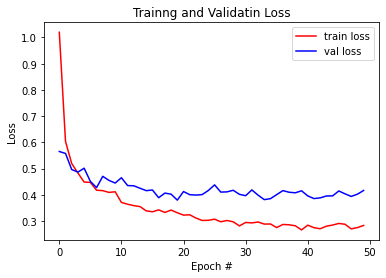

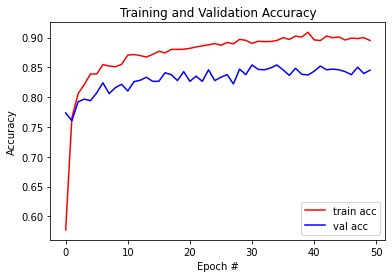

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'],'r', label='train loss')
plt.plot(r.history['val_loss'],'b', label='val loss')
plt.title("Trainng and Validatin Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'],'r', label='train acc')
plt.plot(r.history['val_accuracy'],'b', label='val acc')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
#loss, accuracy = my_model.evaluate(x_test, y_test, verbose=1)
loss, accuracy = model.evaluate(test_set, verbose=1)
# loss_v, accuracy_v = my_model.evaluate(x_validate, y_validate, verbose=1)
t_loss, t_accuracy = model.evaluate(training_set, verbose=1)

201/201 [==============================] - 83s 413ms/step - loss: 0.1683 - accuracy: 0.9528


In [ ]:
print("Training: accuracy = %f  ;  loss_v = %f" % (t_accuracy, t_loss))
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.952789  ;  loss_v = 0.168330
Validation: accuracy = 0.829177  ;  loss = 0.416356


In [ ]:
# save it as a h5 file

model.save('../data/faba_bean_model_inceptionv3_original_image_1.h5')

In [6]:
# open saved model file
my_model = keras.models.load_model('../data/faba_bean_model_inceptionv3_original_image_1.h5')

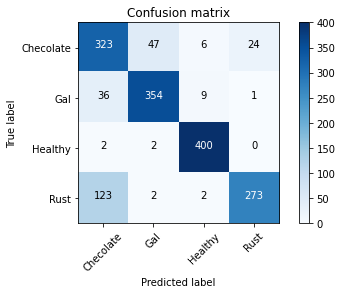

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Get the predicted classes
predictions = my_model.predict(test_set,  1506 // 32 + 1)
predicted_classes = np.argmax(predictions, axis = 1) 

# Get ground-truth classes and class-labels
true_classes = test_set.classes

target_name = ['Checolate', 'Gal', 'Healthy', 'Rust']

confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plot_confusion_matrix(confusion_mtx, classes = target_name) 

Text(0, 0.5, 'Fraction classified incorrectly')

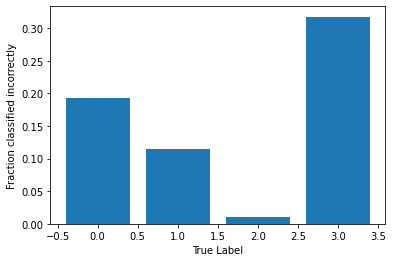

In [9]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(4),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [10]:
print('\nClassification Report\n')
target_name = ['Checolate_spot', 'gal', 'healthy', 'rust']
report = classification_report(true_classes, predicted_classes, target_names=target_name)
print(report)


Classification Report

                precision    recall  f1-score   support

Checolate_spot       0.67      0.81      0.73       400
           gal       0.87      0.89      0.88       400
       healthy       0.96      0.99      0.97       404
          rust       0.92      0.68      0.78       400

      accuracy                           0.84      1604
     macro avg       0.85      0.84      0.84      1604
  weighted avg       0.85      0.84      0.84      1604

